In [52]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt

In [18]:
#Расчет Somers D

def somers_d(xx,yy,weight = None):
    
    '''
    xx - feature
    yy - target
    weight - weights
    '''
    
    if weight is None: weight = np.ones(len(xx))

    x = st.rankdata(xx)
    y = st.rankdata(yy)
    weight = np.array(weight)
    
    n2_const = sum(weight[:-1]*(sum(weight)-np.cumsum(weight[:-1])))
    K, y_adj = 0, 0

    for i in range(len(weight)-1):
        sign_arr_x = np.sign(x[i]-x[i+1:len(weight)])
        sign_arr_y = np.sign(y[i]-y[i+1:len(weight)])
        ww_arr = weight[i]*weight[i+1:]

        K += sum(ww_arr*sign_arr_x*sign_arr_y)
        y_adj += sum(ww_arr*(1 - abs(sign_arr_y*sign_arr_y)))
        
    return K/(n2_const-y_adj)

In [146]:
a = pd.read_excel(io='Data_for_ESG.xlsx',sheet_name='Data_for_ESG_to_load');
a.head()

,ID,Name,ESG rating,ESG_group,E,E_group,S,S_group,G,G_group,...,Kol_vo_sm_ruk_to_Chist_Akt_norm,Ocenka_rabotodat_norm,LN_Chist_Akt_norm,LN_Divid_potok_norm,Dyn_Chist_Akt_norm,Dyn_Divid_potok_norm,Kol_vo_prosr_to_Divid_potok_norm,Smena_yur_adr_to_Chist_Akt_norm,Fakt_ots_gos_z_i_gos_u_norm,Negat_ton_SMI_to_Upom_SMI_norm
0,1,"ПАО ""НЛМК""",AA,5,AA,5,AA,5,A,5,...,0.497354,-2.067108,0.398938,1.408511,0.069261,0.937432,0.668338,0.423460,-0.386828,-0.155364
1,2,"ПАО ""ПОЛЮС""",AA,5,AAA,5,A,5,A,5,...,0.508764,0.045040,1.240233,-1.257278,-0.286120,-1.337801,-1.564891,0.416075,2.559016,-2.064645
2,3,"ПАО ""Уралкалий""",A,5,BBB,4,AA,5,AA,5,...,0.433277,0.045040,-0.241514,1.101580,1.464150,1.155159,0.664469,0.423460,-0.386828,-1.845897
3,4,"ПАО ""ЭЛ-5 Энерго""",A,5,BBB,4,A,5,AAA,5,...,-0.125174,1.687822,-0.784533,-1.257278,-0.722728,-1.337801,-1.564891,0.285556,-0.386828,0.129448
4,5,"АО ""Полиметалл""",A,5,A,5,A,5,AA,5,...,0.516887,0.749090,-0.374931,0.661670,-0.671885,-0.644388,0.671054,0.365112,2.559016,0.988218


In [163]:
#Перебор всех моделей с метриками

#Добавление столбца из единиц
a['rsh_ones'] = np.ones(a.Vakancies_to_Chist_Akt_norm.shape[0])
a.head()
#Переменные для перебора
zz_1 = pd.DataFrame([a.Vakancies_to_Chist_Akt_norm,a.rsh_ones]).transpose();
zz_2 = pd.DataFrame([a.Kol_vo_isk_otv_to_D_pot_norm,a.rsh_ones]).transpose();
zz_3 = pd.DataFrame([a.Kol_vo_sm_ruk_to_Chist_Akt_norm,a.rsh_ones]).transpose();
zz_4 = pd.DataFrame([a.Ocenka_rabotodat_norm,a.rsh_ones]).transpose();

#Инициализация переменных
rsh_S = a;
q = 0;
vars_S = 4;
zzz = [];
thresh = [];
model_rating_S = [];
p_rating_S_max = [];
error_S = [];

reg_2341 = '';
reg_1342 = '';
reg_1243 = '';
reg_1234 = '';
reg_231 = '';
reg_132 = '';
reg_123 = '';
reg_21 = '';

for f in range (0,2):
    for ff in range (0,2):
        for fff in range (0,2):
            for ffff in range (0,2):
                q = q + 1;
                if ((f < 1) or (ff < 1) or (fff < 1) or (ffff < 1)):
                    if (f == 1):
                        vars_S -= 1;       
                    if (ff == 1):
                        vars_S -= 1;
                    if (fff == 1):
                        vars_S -= 1;
                    if (ffff == 1):
                        vars_S -= 1;
                    
                    
                    #Настройка порядковых логистических регрессий
                    rsh_S = pd.DataFrame([zz_1[zz_1.columns[f]],zz_2[zz_2.columns[ff]],zz_3[zz_3.columns[fff]],zz_4[zz_4.columns[ffff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose()
                    mod_log = OrderedModel(a.S_group,rsh_S,distr='logit');
                    res_log = mod_log.fit(method='bfgs', disp=False);

                
                    #Результаты порядковых логистических регрессий
                    predicted = res_log.model.predict(res_log.params, exog=rsh_S);
                    
                    #Получение рейтингов S по наибольшей вероятности нахождения в рейтинге и данная вероятность
                    for gg in range(0,res_log.nobs):
                        model_rating_S.append(1);
                        p_rating_S_max.append(predicted[gg,0]);
                        for ggg in range(1,5):
                            if (predicted[gg,ggg] > p_rating_S_max[gg]):
                                model_rating_S[gg] = ggg+1;
                                p_rating_S_max[gg] = predicted[gg,ggg];
                                                  
                    #Расчет Somers'D на обучении модели
                    Somers_D_build = somers_d(model_rating_S,a.S_group,weight = None);
                
                    #Расчет доли наблюдений с 0,0-1 и 0-1-2 нотчами ошибок
                    kol_vo_0 = 0;
                    kol_vo_0_1 = 0;
                    kol_vo_0_1_2 = 0;
                            
                    for gf in range(0,res_log.nobs):
                        error_S.append(abs(a.S_group[gf] - model_rating_S[gf]));
                        if (error_S[gf] == 0):
                            kol_vo_0 = kol_vo_0 + 1;
                        if (error_S[gf] <= 1):
                            kol_vo_0_1 = kol_vo_0_1 + 1;
                        if (error_S[gf] <= 2):
                            kol_vo_0_1_2 = kol_vo_0_1_2 + 1;
                
                        dolya_error_0_notch = kol_vo_0/res_log.nobs;
                        dolya_error_0_1_notch = kol_vo_0_1/res_log.nobs; 
                        dolya_error_0_1_2_notch = kol_vo_0_1_2/res_log.nobs;
                            
                    #Формирование итоговой выгрузки по итогам перебора
                    zzzz = np.array(pd.DataFrame([zz_1[zz_1.columns[f]],zz_2[zz_2.columns[ff]],zz_3[zz_3.columns[fff]],zz_4[zz_4.columns[ffff]]]).drop(['rsh_ones'],axis=0,errors='ignore').transpose())
                    
                    
                    if (vars_S == 4):   
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                        th_params = [res_log.params[4],res_log.params[5],res_log.params[6],res_log.params[7]];
                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                    #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                        reg_2341 = linear_model.LinearRegression();
                        reg_2341.fit(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());
                        reg_2341_score = reg_2341.score(np.array([zzzz[:,1],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                        reg_1342 = linear_model.LinearRegression();
                        reg_1342.fit(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());
                        reg_1342_score = reg_1342.score(np.array([zzzz[:,0],zzzz[:,2],zzzz[:,3]]).transpose(), np.array([zzzz[:,1]]).transpose());            
                        reg_1243 = linear_model.LinearRegression();
                        reg_1243.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose());
                        reg_1243_score = reg_1243.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,3]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                        reg_1234 = linear_model.LinearRegression();
                        reg_1234.fit(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose());
                        reg_1234_score = reg_1234.score(np.array([zzzz[:,0],zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,3]]).transpose()); 
                    
                    #Вывод результатов перебора для моделей с 4 факторами
                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],mod_log.exog_names[3],abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),
                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3])),abs(-res_log.params[3])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]) + abs(-res_log.params[3]))),
                        res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],-res_log.params[3],thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3]))),max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),2*st.norm.cdf(-abs(res_log.params[3]/math.sqrt(res_log.normalized_cov_params.values[3,3])))),1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score),max(1/(1-reg_2341_score),1/(1-reg_1342_score),1/(1-reg_1243_score),1/(1-reg_1234_score))]); 
                            
                    if (vars_S == 3):   
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                        th_params = [res_log.params[3],res_log.params[4],res_log.params[5],res_log.params[6]];
                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                    #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                        reg_231 = linear_model.LinearRegression();
                        reg_231.fit(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());
                        reg_231_score = reg_231.score(np.array([zzzz[:,1],zzzz[:,2]]).transpose(), np.array([zzzz[:,0]]).transpose());            
                        reg_132 = linear_model.LinearRegression();
                        reg_132.fit(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose());
                        reg_132_score = reg_132.score(np.array([zzzz[:,0],zzzz[:,2]]).transpose(), np.array([zzzz[:,1]]).transpose()); 
                        reg_123 = linear_model.LinearRegression();
                        reg_123.fit(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose());
                        reg_123_score = reg_123.score(np.array([zzzz[:,0],zzzz[:,1]]).transpose(), np.array([zzzz[:,2]]).transpose()); 
                    #Вывод результатов перебора для моделей с 3 факторами
                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],mod_log.exog_names[2],'',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),'',
                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2])),abs(-res_log.params[2])/(abs(-res_log.params[0]) + abs(-res_log.params[1]) + abs(-res_log.params[2]))),
                        res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],-res_log.params[2],0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2]))),'',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),2*st.norm.cdf(-abs(res_log.params[2]/math.sqrt(res_log.normalized_cov_params.values[2,2])))),1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score),'',max(1/(1-reg_231_score),1/(1-reg_132_score),1/(1-reg_123_score))]); 
                            
                    if (vars_S == 2):
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                        th_params = [res_log.params[2],res_log.params[3],res_log.params[4],res_log.params[5]];
                        thresh = np.concatenate((th_params[:1], np.exp(th_params[1:]))).cumsum();
                    #Построение линейных регрессий для оценки мультиколлинеарности (VIF = 1/(1-r2))
                        reg_21 = linear_model.LinearRegression();
                        reg_21.fit(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                        reg_21_score = reg_21.score(np.array([zzzz[:,1]]).transpose(), np.array([zzzz[:,0]]).transpose());
                    #Вывод результатов перебора для моделей с 2 факторами
                        zzz.append([mod_log.exog_names[0],mod_log.exog_names[1],'','',abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),'','',
                        min(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),max(abs(-res_log.params[0])/(abs(-res_log.params[0]) + abs(-res_log.params[1])),abs(-res_log.params[1])/(abs(-res_log.params[0]) + abs(-res_log.params[1]))),
                        res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],-res_log.params[1],0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1]))),'','',max(2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),2*st.norm.cdf(-abs(res_log.params[1]/math.sqrt(res_log.normalized_cov_params.values[1,1])))),1/(1-reg_21_score),1/(1-reg_21_score),'','',1/(1-reg_21_score)]);
                            
                    if (vars_S == 1):
                        
                    #Корректировка свободных членов регрессии по причине их смещения в Питоне
                        th_params = [res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4]];
                        thresh = np.concatenate((th_params[:1],np.exp(th_params[1:]))).cumsum();
                    #Вывод результатов перебора для моделей с 1 фактором
                        zzz.append([mod_log.exog_names[0],'','','',1,'','','',1,1,res_log.nobs,Somers_D_build,dolya_error_0_notch,dolya_error_0_1_notch,dolya_error_0_1_2_notch,res_log.llf,res_log.prsquared,res_log.aic,-res_log.params[0],0,
                        0,0,thresh[0],thresh[1],thresh[2],thresh[3],2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),'','','','','',2*st.norm.cdf(-abs(res_log.params[0]/math.sqrt(res_log.normalized_cov_params.values[0,0]))),1,'','','',1]);
                            
                            
                    vars_S_pre = vars_S;
                    vars_S = 4;
                    model_rating_S = [];
                    p_rating_S_max = [];
                    error_S = [];
                    
#Вывод результатов перебора в Эксель                
zzz_pd=pd.DataFrame(zzz);

zzz_pd.to_excel(excel_writer = "Perebor_S.xlsx",header=['Risk_factor_1','Risk_factor_2','Risk_factor_3','Risk_factor_4','Ves_1','Ves_2','Ves_3','Ves_4','Ves_min','Ves_max','count_obs_build','Somers_D_build','dolya_error_0_notch','dolya_error_0_1_notch','dolya_error_0_1_2_notch',
                                                                                                                 'LogL_build','pseudo_Rsq_build','AIC_build','Regr_koef_1','Regr_koef_2','Regr_koef_3','Regr_koef_4','Intercept_1','Intercept_2','Intercept_3','Intercept_4','p_value_1','p_value_2','p_value_3','p_value_4','p_value_vars_max','VIF_1','VIF_2','VIF_3','VIF_4','VIF_max','?_1','?_2']);                   

/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]
/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ord

In [173]:
#Оптимальная модель для рейтинга S
mod_log = OrderedModel(a.S_group,pd.DataFrame([a['Vakancies_to_Chist_Akt_norm'],a['Kol_vo_sm_ruk_to_Chist_Akt_norm']]).transpose(),
                        distr='logit')
res_log = mod_log.fit(method='bfgs', disp=False)
res_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:                S_group   Log-Likelihood:                -153.10
Model:                   OrderedModel   AIC:                             318.2
Method:            Maximum Likelihood   BIC:                             333.8
Date:                Sat, 30 Sep 2023                                         
Time:                        13:58:33                                         
No. Observations:                  99                                         
Df Residuals:                      93                                         
Df Model:                           6                                         
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Vakancies_to_Chist_Akt_norm         0.4625      0.187      2.468      0.014       0.095       0.830
Kol_vo_sm_ruk_to_Chist_Akt_norm     0.4766      0.203      2.353      0.019       0.080       0.874
1/2                                -1.1460      0.237     -4.828      0.000      -1.611      -0.681
2/3                                 0.0941      0.191      0.494      0.622      -0.279       0.468
3/4                                -0.1544      0.212     -0.727      0.467      -0.571       0.262
4/5                                -0.1350      0.244     -0.552      0.581      -0.614       0.344
===================================================================================================
"""

In [174]:
#Корректировка свободных членов регрессии по причине их смещения в Питоне
th_params = [res_log.params[1],res_log.params[2],res_log.params[3],res_log.params[4]];
thresh = np.concatenate((th_params[:1],
                                 np.exp(th_params[1:]))).cumsum();
print(thresh)
dir(res_log);

[0.47659431 0.79451247 1.89315667 2.75005589]


In [211]:
#Результаты применения оптимальной порядковой логистической регрессии
predicted = res_log.model.predict(res_log.params, exog=a[['Vakancies_to_Chist_Akt_norm','Kol_vo_sm_ruk_to_Chist_Akt_norm']]);

qqq_pred=pd.DataFrame(predicted);
model_rating_S = [];
p_rating_S_max = [];

for gg in range(0,res_log.nobs):
                    model_rating_S.append(1);
                    p_rating_S_max.append(predicted[gg,0]);
                    for ggg in range(1,5):
                        if (predicted[gg,ggg] > p_rating_S_max[gg]):
                            model_rating_S[gg] = ggg+1;
                            p_rating_S_max[gg] = predicted[gg,ggg];

model_rating_S_pred=pd.DataFrame(model_rating_S);


print(qqq_pred);
print(model_rating_S);

Score_S=a.Vakancies_to_Chist_Akt_norm*res_log.params[0]+ a.Kol_vo_sm_ruk_to_Chist_Akt_norm*res_log.params[1];
Score_S_pred=pd.DataFrame(Score_S);
Score_S_pred.to_excel(excel_writer = "Score_S.xlsx");

           0         1         2         3         4
0   0.231128  0.243068  0.205765  0.155838  0.164202
1   0.232145  0.243476  0.205582  0.155379  0.163419
2   0.231670  0.243286  0.205668  0.155593  0.163783
3   0.287089  0.260041  0.192872  0.132101  0.127897
4   0.231098  0.243056  0.205770  0.155852  0.164225
..       ...       ...       ...       ...       ...
94  0.230481  0.242806  0.205880  0.156131  0.164702
95  0.410739  0.265761  0.154767  0.090625  0.078108
96  0.265893  0.254866  0.198337  0.140711  0.140193
97  0.302179  0.262875  0.188675  0.126258  0.120013
98  0.299357  0.262397  0.189476  0.127333  0.121438

[99 rows x 5 columns]
[2, 2, 2, 1, 2, 2, 2, 2, 5, 2, 5, 2, 2, 5, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 5, 5, 5, 1, 2, 2, 2, 5, 2, 2, 5, 5, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 1, 1, 1]


/Users/olegpranikov/anaconda3/lib/python3.10/site-packages/statsmodels/miscmodels/ordinal_model.py:419: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  xb = xb[:, None]


In [208]:
rating_1 = 0
rating_2 = 0 
rating_5 = 0


for i in model_rating_S:
    if i == 1:
        rating_1 += 1
    if i == 2:
        rating_2 += 1
    if i == 5:
        rating_5 += 1 
print(rating_1)
print(rating_2)
print(rating_5)

21
69
9


In [202]:
Somers_D_opt = somers_d(model_rating_S,a.S_group,weight = None);
print(Somers_D_opt);

0.2092125579001544


In [203]:
graph_1 = np.array(a.groupby('S_group').agg('count').ID/a.shape[0]);
print(graph_1);
a['model_rating_S'] = model_rating_E;
graph_2 = np.array(a.groupby('model_rating_S').agg('count').ID/a.shape[0]);
print(graph_2);

[0.25252525 0.23232323 0.19191919 0.15151515 0.17171717]
[0.21212121 0.6969697  0.09090909]


Text(0, 0.5, 'Частота')

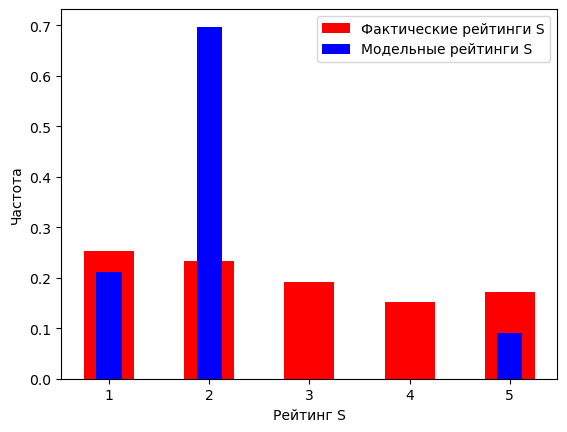

In [209]:
plt.bar([1,2,3,4,5],graph_1,color='red',width=0.5);
plt.bar([1,2,5],graph_2,color='blue',width=0.25);
plt.legend(['Фактические рейтинги S','Модельные рейтинги S']);
plt.xlabel('Рейтинг S', color='black')
plt.ylabel('Частота',color='black')